### Load DataFrame

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import calendar

with open("wiki_deaths.json", "r") as f:
    data = json.load(f)
    df = pd.json_normalize(data, record_path=["months", "days", "deaths"], meta=["year", ["months", "month"], ["months", "days", "day"]]) 
    df.rename(columns={"Name": "Name", "Age": "Age", "Info": "Info", "year": "Year", "months.month": "Month", "months.days.day": "Day"}, inplace=True)
df.head()


,Name,Age,Info,Year,Month,Day
0,Arundhati Devi,66,"Indian actress, director, and singer.",1990,January,1
1,Carmen Hill,94,American baseball player.,1990,January,1
2,Joe Hardstaff Jr,78,English cricket player.,1990,January,1
3,Patrick Kelly,35,"American fashion designer, AIDS.",1990,January,1
4,Ernst Kuzorra,84,German football player.,1990,January,1


### Data Cleaning

#### Adjust column types

In [2]:
df.dtypes

Name     object
Age      object
Info     object
Year     object
Month    object
Day      object
dtype: object

In [3]:
# If Age column has two distinct numbers, e.g. 81-82, transform them into their mean
def fix_age(age):
    if age == None:
        return None
    elif "-" in age:
        age = age.split("-")
        return (int(age[0]) + int(age[1])) / 2
    else:
        return int(age)

df["Age"] = df["Age"].apply(fix_age)

In [4]:
df.sample(10)

,Name,Age,Info,Year,Month,Day
73552,Anders Carlberg,69.0,"Swedish politician, writer and social worker.",2013,January,5
148598,Steve Cotter,81.0,"Canadian football player (BC Lions, Edmonton E...",2022,February,10
68658,Beatrice Brumby,98.0,Australian pastoral and tourism pioneer.,2012,March,31
37414,Leon Wagner,69.0,American Major League Baseball player.,2004,January,3
63483,Rosihan Anwar,88.0,"Indonesian journalist, heart failure.",2011,April,14
139421,Pedro Ivo Ferreira Caminhas,68.0,"Brazilian politician, Minas Gerais MLA (2001–2...",2021,April,11
176202,Colin Chilvers,79.0,"English music video director (""Smooth Criminal...",2024,November,19
167325,Kai Wiedenhöfer,57.0,"German photojournalist, heart attack.",2024,January,9
163245,Richard Murphy,91.0,American Olympic rower.,2023,August,8
135398,John Ahern,86.0,"American politician, member of the Washington ...",2020,December,19


In [5]:
# Transform Month column into a numeric one
df["Month"] = df["Month"].apply(lambda month : list(calendar.month_name).index(month))
df.head()

,Name,Age,Info,Year,Month,Day
0,Arundhati Devi,66.0,"Indian actress, director, and singer.",1990,1,1
1,Carmen Hill,94.0,American baseball player.,1990,1,1
2,Joe Hardstaff Jr,78.0,English cricket player.,1990,1,1
3,Patrick Kelly,35.0,"American fashion designer, AIDS.",1990,1,1
4,Ernst Kuzorra,84.0,German football player.,1990,1,1


In [6]:
# Assign numeric types to Year and Day columns
df = df.astype({"Year": "int64", "Day": "int64"})
df.dtypes

Name      object
Age      float64
Info      object
Year       int64
Month      int64
Day        int64
dtype: object

#### Fix NaN Info column

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177400 entries, 0 to 177399
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Name    177400 non-null  object 
 1   Age     176301 non-null  float64
 2   Info    177390 non-null  object 
 3   Year    177400 non-null  int64  
 4   Month   177400 non-null  int64  
 5   Day     177400 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 8.1+ MB


In [8]:
# Find empty Info rows (lines not splitted)
df[df["Info"].isna()]

,Name,Age,Info,Year,Month,Day
29291,"K. Thavamani Devi, Sri Lankan actress.",NaN,None,2001,2,10
49708,[[David Watkin,NaN,None,2008,2,19
59535,"K. M. M. B. Kulatunga, Sri Lankan puisne justi...",NaN,None,2010,6,3
59985,"Bob Harvie, Sri Lankan cricket commentator.",NaN,None,2010,7,7
64682,John Brown Davidson (Jackie Or jack),NaN,None,2011,7,13
160997,Yousef Mehrdad,NaN,None,2023,5,8
160998,Sadrollah Fazeli Zare,NaN,None,2023,5,8
166154,"Mali, Sri Lankan-born Asian elephant (Manila Z...",NaN,None,2023,11,28
171725,"Siri Kannangara, Sri Lankan-Australian sports ...",NaN,None,2024,6,7
175228,"Bati Penia, Sri Lankan-Fijian rugby sevens pla...",NaN,None,2024,10,16


In [9]:
# Some splits didn't occur during data scraping because of "Sr" (Senior) in "Sri Lankan"
def fix_noinfo(text):
    text = re.split(", ", text, maxsplit=1)
    if len(text) != 1:
        return text
    else:
        return [text[0], None]

new_values = df[df["Info"].isna()]["Name"].apply(fix_noinfo)
print(new_values)

29291              [K. Thavamani Devi, Sri Lankan actress.]
49708                                [[[David Watkin, None]
59535     [K. M. M. B. Kulatunga, Sri Lankan puisne just...
59985         [Bob Harvie, Sri Lankan cricket commentator.]
64682          [John Brown Davidson (Jackie Or jack), None]
160997                               [Yousef Mehrdad, None]
160998                        [Sadrollah Fazeli Zare, None]
166154    [Mali, Sri Lankan-born Asian elephant (Manila ...
171725    [Siri Kannangara, Sri Lankan-Australian sports...
175228    [Bati Penia, Sri Lankan-Fijian rugby sevens pl...
Name: Name, dtype: object


In [10]:
df.loc[df["Info"].isna(), ["Name", "Info"]] = new_values.tolist()

In [11]:
df[df["Info"].isna()]

,Name,Age,Info,Year,Month,Day
49708,[[David Watkin,NaN,None,2008,2,19
64682,John Brown Davidson (Jackie Or jack),NaN,None,2011,7,13
160997,Yousef Mehrdad,NaN,None,2023,5,8
160998,Sadrollah Fazeli Zare,NaN,None,2023,5,8


In [12]:
# Checking Wikipedia, last two rows are about two Iranian blasphemers
df.loc[[160997, 160998], "Info"] = "Iranian blasphemer, hanged"

In [13]:
df.loc[[160997, 160998]]

,Name,Age,Info,Year,Month,Day
160997,Yousef Mehrdad,NaN,"Iranian blasphemer, hanged",2023,5,8
160998,Sadrollah Fazeli Zare,NaN,"Iranian blasphemer, hanged",2023,5,8


In [14]:
# First two rows are just names without any info or related page, so can be dropped from df
df.drop(labels=[49708, 64682], axis=0, inplace=True)
df[df["Info"].isna()]

,Name,Age,Info,Year,Month,Day


#### Fix high Age values

In [15]:
# Search for too high Age values
df[df["Age"] > 130]

,Name,Age,Info,Year,Month,Day
39761,"Alfred Maseng, Vanuatuan president (1994",2004.0,) and foreign minister (1995–1996).,2004,11,18
43647,Adwaita,255.0,"(approximate age), tortoise claimant for world...",2006,3,23
44328,Harriet,176.0,Galápagos tortoise believed to be the third ol...,2006,6,23
67288,The Senator,3500.0,"American pond cypress tree, largest in the wor...",2012,1,16
71614,"Pape Alioune Diop, Senegalese football player ...",1982.0,"–1986), Alzheimer's disease.",2012,9,26
77177,"Bhagwati Prasad, Indian politician, Uttar Prad...",1969.0,"–1974), multiple organ failure.",2013,7,9
89637,Tuti Yusupova,134.0,"?, Uzbekistani longevity claimant, unverified ...",2015,3,28
101570,Pioneer Cabin Tree,1000.0,"American giant sequoia tree, storm damage.",2017,1,8
103927,Mbah Gotho,146.0,"(claimed), Indonesian longevity claimant, olde...",2017,4,30
122433,"Mohammad Muslim, Indian politician, MLA (1996–...",2012.0,–2017).,2019,8,29


In [16]:
# While some rows are valid (ancient trees, animals and self-proclaimed ages), others result from wrong regex application
# Filter rows to fix
df[(df["Age"] > 1000) & (df.index != 67288)]

,Name,Age,Info,Year,Month,Day
39761,"Alfred Maseng, Vanuatuan president (1994",2004.0,) and foreign minister (1995–1996).,2004,11,18
71614,"Pape Alioune Diop, Senegalese football player ...",1982.0,"–1986), Alzheimer's disease.",2012,9,26
77177,"Bhagwati Prasad, Indian politician, Uttar Prad...",1969.0,"–1974), multiple organ failure.",2013,7,9
122433,"Mohammad Muslim, Indian politician, MLA (1996–...",2012.0,–2017).,2019,8,29
126798,"Satya Nandan, Fijian diplomat, representative ...",1993.0,–1995) and ambassador to the Netherlands (1976...,2020,2,25
134908,"Kiptarus Arap Kirior, Kenyan politician, MP (1...",1992.0,–1997).,2020,12,3
140761,"Tshoganetso Tongwane, South African politician...",2014.0,"–2019, since 2019), COVID-19.",2021,5,20
146028,"Galal Ibrahim, Egyptian football executive, pr...",2010.0,–2011).,2021,11,25
155415,"Martine Djibo, Ivorian educator and politician...",1990.0,–2010).,2022,10,30
155747,"Rabin Banikya, Indian politician, member of th...",2006.0,–2011).,2022,11,11


In [17]:
def correct_name_info(row):
    name_info = re.split(", ", row["Name"], maxsplit=1)
    return [name_info[0], name_info[1] + " " + str(int(row["Age"])) + row["Info"]]
 
correct_data = df[(df["Age"] > 1000) & (df.index != 67288)].apply(correct_name_info, axis=1).tolist()
print(correct_data)

[['Alfred Maseng', 'Vanuatuan president (1994 2004) and foreign minister (1995–1996).'], ['Pape Alioune Diop', "Senegalese football player and manager (national team 1982–1986), Alzheimer's disease."], ['Bhagwati Prasad', 'Indian politician, Uttar Pradesh MLA for Ikauna (1967–1969 1969–1974), multiple organ failure.'], ['Mohammad Muslim', 'Indian politician, MLA (1996–2002 2012–2017).'], ['Satya Nandan', 'Fijian diplomat, representative to the United Nations (1970–1976 1993–1995) and ambassador to the Netherlands (1976–1980).'], ['Kiptarus Arap Kirior', 'Kenyan politician, MP (1983–1988 1992–1997).'], ['Tshoganetso Tongwane', 'South African politician, MP (2008–2014 2014–2019, since 2019), COVID-19.'], ['Galal Ibrahim', 'Egyptian football executive, president of Zamalek (1992–1996 2010–2011).'], ['Martine Djibo', 'Ivorian educator and politician, MP (1975–1980 1990–2010).'], ['Rabin Banikya', 'Indian politician, member of the Assam Legislative Assembly (1996–2001 2006–2011).'], ['Gayat

In [18]:
# Assign correct Name and Info
df.loc[(df["Age"] > 1000) & (df.index != 67288), ["Name", "Info"]] = correct_data

In [19]:
# Set incorrect age to NaN
df.loc[(df["Age"] > 1000) & (df.index != 67288), ["Age"]] = np.nan

In [20]:
# Check results
df.loc[(df["Age"] > 120)]

,Name,Age,Info,Year,Month,Day
19360,Jeanne Calment,122.0,French supercentenarian and the oldest person ...,1997,8,4
43647,Adwaita,255.0,"(approximate age), tortoise claimant for world...",2006,3,23
44328,Harriet,176.0,Galápagos tortoise believed to be the third ol...,2006,6,23
45239,Benito Martínez,126.0,"?, Cuban claimant to the title of world's olde...",2006,10,11
67288,The Senator,3500.0,"American pond cypress tree, largest in the wor...",2012,1,16
76510,Luo Meizhen,127.0,"?, Chinese unverified claimant for world's old...",2013,6,4
81274,Eisenhower Tree,125.0,American loblolly pine (Augusta National Golf ...,2014,2,16
89429,Leandra Becerra Lumbreras,127.0,"?, Mexican longevity claimant, unverified olde...",2015,3,19
89637,Tuti Yusupova,134.0,"?, Uzbekistani longevity claimant, unverified ...",2015,3,28
101570,Pioneer Cabin Tree,1000.0,"American giant sequoia tree, storm damage.",2017,1,8


#### Fix low Age values

In [21]:
# Search for low Age values
df[df["Age"] < 10]

,Name,Age,Info,Year,Month,Day
559,Hugh Cholmondeley,6.0,"th Marquess of Cholmondeley, 70, British hered...",1990,3,13
608,Victor Rothschild,3.0,"rd Baron Rothschild, 79, British banker and in...",1990,3,20
1138,Thomas Ponsonby,3.0,"rd Baron Ponsonby of Shulbrede, 59, British po...",1990,6,13
1432,Victor Cavendish-Bentinck,9.0,"th Duke of Portland, 93, British diplomat.",1990,7,30
1610,Sir Peter Agnew,1.0,"st Baronet, 90, British politician.",1990,8,26
...,...,...,...,...,...,...
172359,Neil Primrose,7.0,"th Earl of Rosebery, 95, British nobleman, mem...",2024,6,30
173259,Anthony Hamilton-Smith,3.0,"rd Baron Colwyn, 82, British dentist and peer,...",2024,8,4
174358,Malcolm Mitchell-Thomson,3.0,"rd Baron Selsdon, 86, British peer, banker and...",2024,9,15
174936,Hugh Cholmondeley,5.0,"th Baron Delamere, 90, British peer, member of...",2024,10,7


In [22]:
# Many nobles were parsed incorrectly, getting their age from a number in their title
nobles = df[(df["Age"] < 30) & (df["Info"].str.contains(r"(Baron(net)? |Duke |Duchess |Marquis |Marquesse |Earl )", regex=True))]
nobles.sample(15)

/tmp/ipykernel_4712/3977804005.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  nobles = df[(df["Age"] < 30) & (df["Info"].str.contains(r"(Baron(net)? |Duke |Duchess |Marquis |Marquesse |Earl )", regex=True))]


,Name,Age,Info,Year,Month,Day
66438,David Seely,4.0,"th Baron Mottistone, 91, British aristocrat, L...",2011,11,24
38289,John Henniker-Major,8.0,"th Baron Henniker, 88, British diplomat and ar...",2004,4,29
122649,Christopher James,5.0,"th Baron Northbourne, 93, British aristocrat, ...",2019,9,8
42596,Patrick Anson,5.0,"th Earl of Lichfield, 66, British peer and pho...",2005,11,11
113953,Peter Mond,4.0,"th Baron Melchett, 70, British environmentalis...",2018,8,29
70634,Peter Evans-Freke,11.0,"th Baron Carbery, 92, Anglo-Irish peer.",2012,7,28
105906,David Somerset,11.0,"th Duke of Beaufort, 89, British peer, member ...",2017,8,16
157389,Thomas Stonor,7.0,"th Baron Camoys, 82, British banker and peer, ...",2023,1,4
75559,Ian Balfour,2.0,"nd Baron Balfour of Inchrye, 88, British hered...",2013,4,14
98348,Peregrine Eliot,10.0,"th Earl of St Germans, 75, British aristocrat ...",2016,7,15


In [23]:
# Verify if all nobles have (wrong) Age value in their Info column
nobles[~nobles["Info"].str.contains(r", (?P<age>\d{2,3}),", regex=True)]

/tmp/ipykernel_4712/1348013420.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  nobles[~nobles["Info"].str.contains(r", (?P<age>\d{2,3}),", regex=True)]


,Name,Age,Info,Year,Month,Day
19136,William Cadogan,7.0,"th Earl Cadogan, British peer and military off...",1997,7,4
70581,Prime Defender,8.0,"British racehorse, winner of the Duke of York ...",2012,7,24


In [24]:
# "Prime Defender" is an already valid row, only "William Cadogan" doesn't have age in his info
# Fix William Cadogan
df.loc[19136, "Name"] = df.loc[19136, "Name"] + ", " + "7" + df.loc[19136, "Info"][:15] 
df.loc[19136, "Age"] = np.nan
df.loc[19136, "Info"] = df.loc[19136, "Info"][17:]
df.loc[19136]

Name      William Cadogan, 7th Earl Cadogan
Age                                     NaN
Info     British peer and military officer.
Year                                   1997
Month                                     7
Day                                       4
Name: 19136, dtype: object

In [25]:
# Exclude Prime Defender from nobles
nobles = df[(df["Age"] < 30) & (df["Info"].str.contains(r"(Baron(net)? |Duke |Duchess |Marquis |Marquesse |Earl )", regex=True)) & (df.index != 70581)]
nobles[~nobles["Info"].str.contains(r", (?P<age>\d{2,3}),", regex=True)]

/tmp/ipykernel_4712/4037256283.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  nobles = df[(df["Age"] < 30) & (df["Info"].str.contains(r"(Baron(net)? |Duke |Duchess |Marquis |Marquesse |Earl )", regex=True)) & (df.index != 70581)]
/tmp/ipykernel_4712/4037256283.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  nobles[~nobles["Info"].str.contains(r", (?P<age>\d{2,3}),", regex=True)]


,Name,Age,Info,Year,Month,Day


In [26]:
# Find correct values
def fix_nobles(row):
    line = row["Name"] + ", " + str(int(row["Age"])) + row["Info"]
    age = re.search(r", (?P<age>\d{2,3}),", line).group("age")
    name, info = re.split(r", \d{2,3},", line, maxsplit=1)
    return [name, float(age), info.strip()]
  
correct_nobles = nobles.apply(fix_nobles, axis=1).tolist()
print(correct_nobles)

[['Victor Rothschild, 3rd Baron Rothschild', 79.0, 'British banker and intelligence officer.'], ['Thomas Ponsonby, 3rd Baron Ponsonby of Shulbrede', 59.0, 'British politician.'], ['Victor Cavendish-Bentinck, 9th Duke of Portland', 93.0, 'British diplomat.'], ['Francis Hastings, 16th Earl of Huntingdon', 89.0, 'British politician and artist.'], ['Rowland Baring, 3rd Earl of Cromer', 72.0, 'British diplomat.'], ['Alexander Baring, 6th Baron Ashburton', 93.0, 'British businessman and politician.'], ['Martin Attlee, 2nd Earl Attlee', 63.0, 'British politician.'], ['Michael Hicks Beach, 2nd Earl St Aldwyn', 79.0, 'British politician.'], ['Charles Carnegie, 11th Earl of Southesk', 98.0, 'British noble.'], ['John Spencer, 8th Earl Spencer', 68.0, 'English peer, courtier, and father of Diana, Princess of Wales, heart attack.'], ['Peter Legh, 4th Baron Newton', 77.0, 'British politician.'], ['Benjamin Guinness, 3rd Earl of Iveagh', 55.0, 'Irish businessman and politician, cancer.'], ['Massey Lo

In [27]:
# Assign correct values
df.loc[(df["Age"] < 30) & (df["Info"].str.contains(r"(Baron(net)? |Duke |Duchess |Marquis |Marquesse |Earl )", regex=True)) & (df.index != 70581), 
       ["Name", "Age", "Info"]] = correct_nobles

/tmp/ipykernel_4712/4202461035.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df.loc[(df["Age"] < 30) & (df["Info"].str.contains(r"(Baron(net)? |Duke |Duchess |Marquis |Marquesse |Earl )", regex=True)) & (df.index != 70581),


In [28]:
# Check results
df[df["Age"] < 10]

,Name,Age,Info,Year,Month,Day
559,Hugh Cholmondeley,6.0,"th Marquess of Cholmondeley, 70, British hered...",1990,3,13
1610,Sir Peter Agnew,1.0,"st Baronet, 90, British politician.",1990,8,26
2907,Sir George Clark,3.0,"rd Baronet, 77, Northern Irish politician.",1991,2,20
3217,William Sidney,1.0,"st Viscount De L'Isle, 81, English-Australian ...",1991,4,5
3772,Sheree Beasley,6.0,Australian murder victim.,1991,6,29
...,...,...,...,...,...,...
168607,Verry Elleegant,8.0,"Australian racehorse, complications from foaling.",2024,2,18
169131,Pigcasso,7.0,"South African painting pig, rheumatoid arthrit...",2024,3,6
169722,Danka Ilić,1.0,"Serbian girl, killed.",2024,3,26
171037,Michael Brudenell-Bruce,8.0,"th Marquess of Ailesbury, 98, British heredita...",2024,5,12


In [29]:
# Still many nobles to fix, try with another pattern
df[df["Info"].str.contains(r"^(st |nd |rd |th )")]

/tmp/ipykernel_4712/3077251369.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[df["Info"].str.contains(r"^(st |nd |rd |th )")]


,Name,Age,Info,Year,Month,Day
559,Hugh Cholmondeley,6.0,"th Marquess of Cholmondeley, 70, British hered...",1990,3,13
1610,Sir Peter Agnew,1.0,"st Baronet, 90, British politician.",1990,8,26
2437,Johannes,11.0,"th Prince of Thurn and Taxis, 64, German busin...",1990,12,14
2907,Sir George Clark,3.0,"rd Baronet, 77, Northern Irish politician.",1991,2,20
3217,William Sidney,1.0,"st Viscount De L'Isle, 81, English-Australian ...",1991,4,5
...,...,...,...,...,...,...
171037,Michael Brudenell-Bruce,8.0,"th Marquess of Ailesbury, 98, British heredita...",2024,5,12
174029,Flora Fraser,21.0,"st Lady Saltoun, 93, Scottish peer, member of ...",2024,9,3
174763,Michael Ancram,13.0,"th Marquess of Lothian, 79, British politician...",2024,10,1
176025,John Skeffington,14.0,"th Viscount Massereene, 84, British peer, memb...",2024,11,13


In [30]:
# Check again if age is reported in Info column and if Age column is NaN
nobles = df[df["Info"].str.contains(r"^(st |nd |rd |th )")]
nobles[~nobles["Info"].str.contains(r", (?P<age>\d{2,3}),", regex=True)]
nobles[nobles["Age"].isna()]

/tmp/ipykernel_4712/2097976194.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  nobles = df[df["Info"].str.contains(r"^(st |nd |rd |th )")]
/tmp/ipykernel_4712/2097976194.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  nobles[~nobles["Info"].str.contains(r", (?P<age>\d{2,3}),", regex=True)]


,Name,Age,Info,Year,Month,Day


In [31]:
# Find correct values
correct_nobles = nobles.apply(fix_nobles, axis=1).tolist()
print(correct_nobles)

[['Hugh Cholmondeley, 6th Marquess of Cholmondeley', 70.0, 'British hereditary peer.'], ['Sir Peter Agnew, 1st Baronet', 90.0, 'British politician.'], ['Johannes, 11th Prince of Thurn and Taxis', 64.0, 'German businessman and noble, complications from heart surgery.'], ['Sir George Clark, 3rd Baronet', 77.0, 'Northern Irish politician.'], ["William Sidney, 1st Viscount De L'Isle", 81.0, 'English-Australian politician, Governor-General of Australia (1961–1965).'], ['Sir Godfrey Nicholson, 1st Baronet', 89.0, 'British politician.'], ['Sir Ewan Forbes, 11th Baronet', 79.0, 'Scottish nobleman, general practitioner and farmer.'], ['Prince Emich, 7th Prince of Leiningen', 65.0, 'German noble and entrepreneur.'], ['Henry Thynne, 6th Marquess of Bath', 87.0, 'British aristocrat and politician.'], ['John Maclay, 1st Viscount Muirshiel', 86.0, 'British politician.'], ['Sir John Rodgers, 1st Baronet', 86.0, 'British politician.'], ['Edward Ward, 7th Viscount Bangor', 87.0, 'English-Irish heredita

In [32]:
# Apply correct values
df.loc[df["Info"].str.contains(r"^(st |nd |rd |th )"), ["Name", "Age", "Info"]] = correct_nobles

/tmp/ipykernel_4712/2693823629.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df.loc[df["Info"].str.contains(r"^(st |nd |rd |th )"), ["Name", "Age", "Info"]] = correct_nobles


In [33]:
# Check results
df[df["Age"] < 10].sample(15)

,Name,Age,Info,Year,Month,Day
79590,Elwood,8.0,"American Chinese crested/chihuahua dog, World'...",2013,11,28
44505,Wiarton Willie,8.0,Canadian Groundhog Day prognosticator.,2006,7,11
78840,Giant George,7.0,"American Great Dane, world's tallest dog.",2013,10,17
92598,Brown Panther,7.0,"British Thoroughbred racehorse, euthanized aft...",2015,9,13
131849,Cannon Hinnant,5.0,"American child, shot.",2020,8,9
51053,Just An Excuse,9.0,"New Zealand Standardbred racehorse, euthanized.",2008,6,30
105966,Olivia Gant,7.0,"American child, starvation.",2017,8,20
70581,Prime Defender,8.0,"British racehorse, winner of the Duke of York ...",2012,7,24
47628,Riley Ann Sawyers,2.0,American murder victim.,2007,7,24
68917,Synchronised,9.0,"Irish racehorse, euthanised after race fall.",2012,4,14


### Number of notable deaths reported on Wikipedia through the years

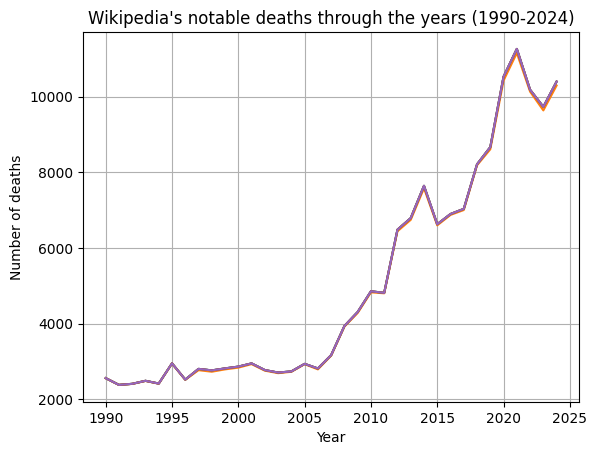

In [34]:
plt.plot(np.sort(df["Year"].unique()), df.groupby(["Year"]).count())
plt.grid()
plt.xlabel("Year")
plt.ylabel("Number of deaths")
plt.title("Wikipedia's notable deaths through the years (1990-2024)")
plt.show()

### Find total deaths for each month

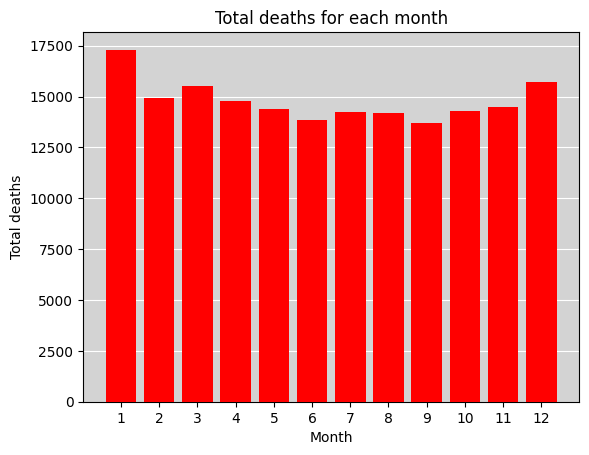

In [43]:
plt.bar(np.sort(df["Month"].unique()), df.groupby(["Month"])["Name"].count(), color="red", zorder=3)
plt.xticks(np.sort(df["Month"].unique()))
plt.xlabel("Month")
plt.ylabel("Total deaths")
plt.grid(axis="y", color="white", zorder=0)
plt.gca().set_facecolor("lightgray")
plt.title("Total deaths for each month")
plt.show()

### Find average age of death through the years

In [59]:
avg_death = df["Age"].mean()
print(f"Average age of death: {avg_death:.2f}")

Average age of death: 76.83


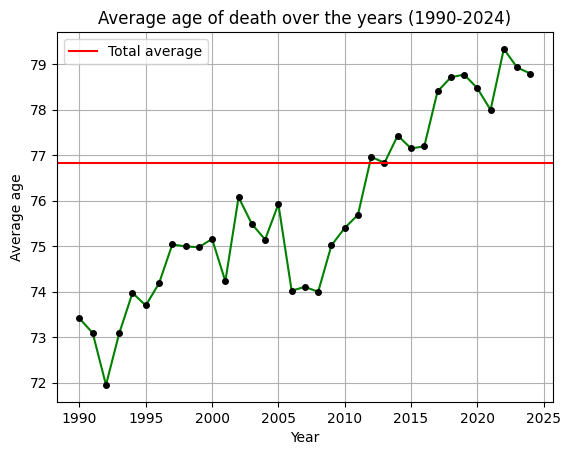

In [63]:
plt.plot(np.sort(df["Year"].unique()), df.groupby("Year")["Age"].mean(), color="green", marker=".", markersize=8, markerfacecolor="black", mec="black")
plt.axhline(y=avg_death, color="red", label="Total average")
plt.grid()
plt.xlabel("Year")
plt.ylabel("Average age")
plt.title("Average age of death over the years (1990-2024)")
plt.legend()
plt.show()

### Find age distribution at death

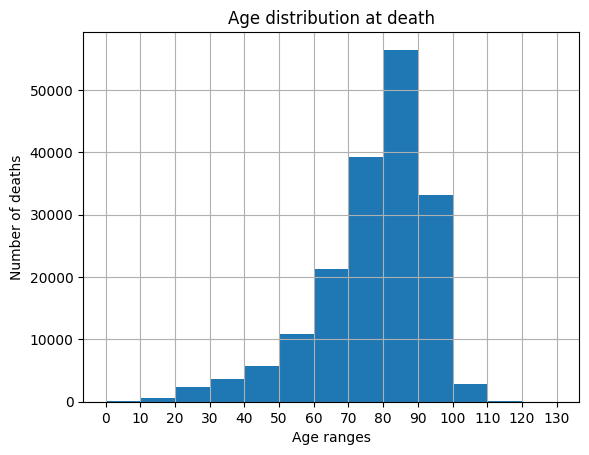

In [69]:
plt.hist(df["Age"], bins=range(0, 140, 10))
plt.xticks(range(0, 140, 10))
plt.xlabel("Age ranges")
plt.ylabel("Number of deaths")
plt.grid()
plt.title("Age distribution at death")
plt.show()